# STalign

https://jef.works/STalign/overview.html#installation-import

First of all, let's create the environment named ´stalign_env´ with Python 3.10.15.

In particular, we are going to focus on this [tutorial](https://jef.works/STalign/notebooks/merfish-visium-alignment-with-point-annotator.html):\
**Aligning single-cell resolution spatial transcriptomics data to H&E staining image from Visium**

bash
conda create -n stalign_env python=3.10
conda remove -n stalign_env --all
conda activate stalign_env


In [1]:
## import dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd
import torch
import plotly
import requests

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [2]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [3]:
from STalign import STalign

let's read the H&E stained image

In [4]:
image_file = '../data/spatial_atac/HE Images sATAC paper/BCSA4_A2_sATAC_C1_adjacent-Spot000001.jpg'
V = plt.imread(image_file)


This step takes a while (13 mins).

In [5]:
print("The initial shape of V is {}".format(V.shape))
print("The range of V is {} to {}".format(V.min(), V.max() ))

Vnorm = STalign.normalize(V)
print("The range of V after normalization is {} to {}".format(Vnorm.min(), Vnorm.max() ))

The initial shape of V is (48128, 47616, 3)
The range of V is 4 to 255
The range of V after normalization is 0.0 to 1.0


loading the IHC cropped image.

In [6]:
ihc_image = '../data/spatial_atac/spatial/220327_C1_cropped.jpg'
I = plt.imread(ihc_image)

In [7]:
print("The initial shape of I is {}".format(I.shape))
print("The range of I is {} to {}".format(I.min(), I.max() ))

Inorm = STalign.normalize(I)
print("The range of I after normalization is {} to {}".format(Inorm.min(), Inorm.max() ))

The initial shape of I is (11438, 10914, 3)
The range of I is 0 to 255
The range of I after normalization is 0.0 to 1.0


In [8]:
# double check size of things
print("The new shape of I is {}".format(Inorm.shape))

The new shape of I is (11438, 10914, 3)


In [9]:
J = Vnorm.transpose(2,0,1)
print("The new shape of J is {}".format(J.shape))

YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

The new shape of J is (3, 48128, 47616)


In [10]:
c1_spots = '../data/spatial_atac/spatial/220327_C1_tissue.csv'
df1 = pd.read_csv(c1_spots)
print(df1.head())

           Unnamed: 0  tissue  V1  V2    V3     V4
0  CCGACCACCCTACGCG-1       1   1   1  4875  30160
1  TTGGGCGGACCGAAGC-1       1   1   3  4975  30160
2  GAAGCCCGCTGCAATC-1       1   3   1  4875  30334
3  AAGCCATAGTCGCGAC-1       1   2   2  4925  30247
4  TCGGGATCTCCGACGA-1       1   3   3  4975  30334


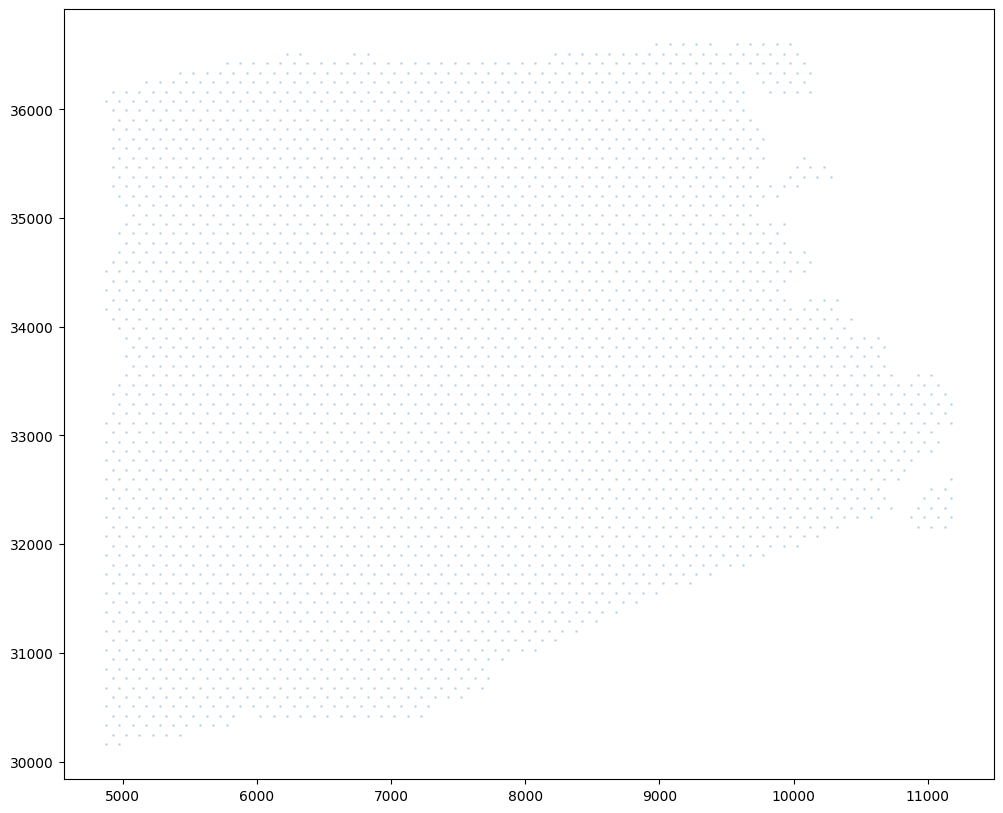

In [11]:
# get cell centroid coordinates
xI = np.array(df1['V3'])
yI = np.array(df1['V4'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2)
#ax.set_aspect('equal', 'box')

0 of 3538


3537 of 3538


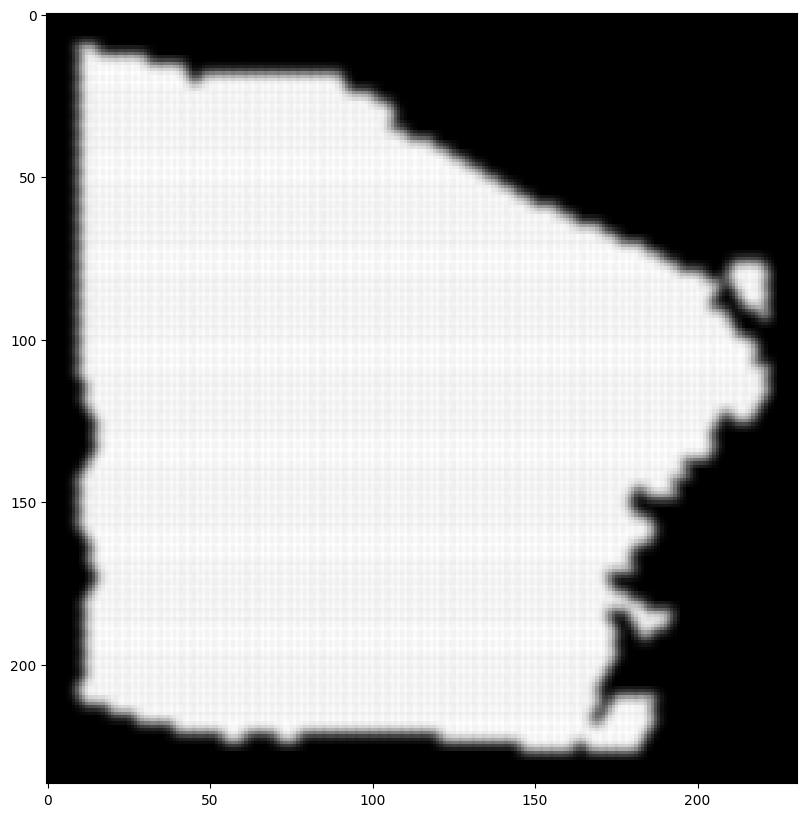

In [12]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XI,YI,I,fig = STalign.rasterize(xI, yI, dx=30)

ax = fig.axes[0]
#ax.invert_yaxis()

In [13]:
print("The initial shape of I is {}".format(I.shape))
I = np.vstack((I, I, I)) # make into 3xNxM
print("The range of I is {} to {}".format(I.min(), I.max() ))

# normalize
I = STalign.normalize(I)
print("The range of I after normalization is {} to {}".format(I.min(), I.max() ))

# double check size of things
print("The new shape of I is {}".format(I.shape))

The initial shape of I is (1, 237, 231)
The range of I is 0.0 to 0.10765346630272236
The range of I after normalization is 0.0 to 1.0
The new shape of I is (3, 237, 231)


In [14]:
# get extent of images
extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))

link to point_annotator.py:
https://github.com/JEFworks-Lab/STalign/blob/main/STalign/point_annotator.py

In [15]:
np.savez('./output/ihc_raster', x=XI,y=YI,I=I)
np.savez('./output/he_image', x=XJ,y=YJ,I=J)

In the terminal:

```bash
python ../utils/point_annotator.py ./ihc_raster.npz ./he_image.npz
```

In [9]:
# read from file
ihc_data = np.load('./output/ihc_raster.npz', allow_pickle=True)#.tolist()
he_data = np.load('./output/he_image.npz', allow_pickle=True)#.tolist()

# Inspect file contents
print(ihc_data.files)
print(he_data.files)

['x', 'y', 'I']
['x', 'y', 'I']


In [ ]:
# Inspect file contents
print(ihc_data.files)
print(he_data.files)


In [ ]:
# convert to array
pointsI = []
pointsJ = []

for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])

pointsI = np.array(pointsI)
pointsJ = np.array(pointsJ)

In [ ]:
# now arrays
print(pointsI)
print(pointsJ)

In [ ]:

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI)
ax[0].invert_yaxis()
ax[0].set_title('source', fontsize=15)
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)
ax[1].set_title('target', fontsize=15)

In [ ]:
#apply A to sources points in row, column (y,x) orientation
affine = np.matmul(np.array(A.cpu()),np.array([yI, xI, np.ones(len(xI))]))

xIaffine = affine[1,:]
yIaffine = affine[0,:]


#apply A to sources landmark points in row, column (y,x) orientation
ypointsI = pointsI[:,0]
xpointsI = pointsI[:,1]
affine = np.matmul(np.array(A.cpu()),np.array([ypointsI, xpointsI, np.ones(len(ypointsI))]))

xpointsIaffine = affine[1,:]
ypointsIaffine = affine[0,:]
pointsIaffine = np.column_stack((ypointsIaffine,xpointsIaffine))


# plot results
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ)

ax.scatter(xIaffine,yIaffine,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(pointsIaffine[:,1],pointsIaffine[:,0],c="blue", label='source landmarks aligned', s=100)

ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', label='target landmarks', s=100)
ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])

ax.set_title('Landmark-based Affine Alignment', fontsize=15)